# A comprehensive data analysis on child reLATed crimes during 2023 and 2024 in Los Angeles from data given by LAPD (Los Angeles Police Department).

# Data Source and Information

Resource Type : Dataset

Metadata Created Date : November 10, 2020

Metadata Updated Date : December 13, 2024

Publisher : data.lacity.org

Maintainer : LAPD OpenData

Identifier : https://data.lacity.org/api/views/2nrs-mtv8

Data First Published : 2020-02-10

Data Last Modified : 2024-12-12

Category : Public Safety

Public Access Level : public

License : http://creativecommons.org/publicdomain/zero/1.0/legalcode

Refresh rate : Bi-monthly


Let's get the necessary libariries first . . . 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
from folium.plugins import HeatMap
import random
import requests
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fetching Crime Data from API and Storing it in MongoDB


In [ ]:
# URL to fetch the response from the API
columns = 'dr_no, Date Rptd, DATE OCC, TIME OCC, AREA, AREA NAME, rpt_dist_no, part_1_2, Crm Cd, Crm Cd Desc, mocodes, Vict Age, Vict Sex, Vict Descent, premis_cd, Premis Desc, Weapon Used Cd, Weapon Desc, status, Status Desc, Crm Cd_1, Crm Cd_2, Crm Cd_3, Crm Cd_4, location, cross_street, LAT, LON'
query = f"$query=SELECT {columns} WHERE UPPER(Crm Cd Desc) LIKE '%CHILD%' AND DATE OCC >= '2023-01-01' AND DATE OCC < '2024-12-16' LIMIT 3000"
url = f"https://data.lacity.org/resource/2nrs-mtv8.json?{query}"

# Fetching the data using the requests package
response = requests.get(url)
data = response.json()

# Connect to MongoDB (ensure MongoDB is running)
client = MongoClient('mongodb://localhost:27017/')  # Adjust the URL if necessary
db = client['crime_data']  # Name of the database
collection = db['crimes']  # Name of the collection

# # Inserting the JSON data into the MongoDB collection
# collection.insert_many(data)

print("Data inserted into MongoDB successfully!")


Data inserted into MongoDB successfully!


# Retrieving Crime Data from MongoDB and Saving it as a CSV for Analysis


In [ ]:
# Retrieve data from MongoDB
data_from_mongo = list(collection.find())

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data_from_mongo)

# Drop the MongoDB's _id field, as it's not needed for analysis
df.drop('_id', axis=1, inplace=True)

# Save the data to a CSV file
df.to_csv('output/crime_data_2023_2024.csv', index=False)

print("Data saved to crime_data_2023_2024.csv successfully!")


Data saved to crime_data_2023_2024.csv successfully!


# Let's open the generated csv as a dataframe to analyse the data 

In [53]:
import pandas as pd 

data = pd.read_excel("output/crime_data.xlsx")


# Data Charecteristics 

In [54]:
data.shape

(7264, 28)

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7264 entries, 0 to 7263
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DR_NO           7264 non-null   int64  
 1   Date Rptd       7264 non-null   object 
 2   DATE OCC        7264 non-null   object 
 3   TIME OCC        7264 non-null   int64  
 4   AREA            7264 non-null   int64  
 5   AREA NAME       7264 non-null   object 
 6   Rpt Dist No     7264 non-null   int64  
 7   Part 1-2        7264 non-null   int64  
 8   Crm Cd          7264 non-null   int64  
 9   Crm Cd Desc     7264 non-null   object 
 10  Mocodes         7089 non-null   object 
 11  Vict Age        7264 non-null   int64  
 12  Vict Sex        7264 non-null   object 
 13  Vict Descent    7264 non-null   object 
 14  Premis Cd       7264 non-null   int64  
 15  Premis Desc     7264 non-null   object 
 16  Weapon Used Cd  4669 non-null   float64
 17  Weapon Desc     4669 non-null   o

In [56]:
data.isnull().sum()

DR_NO                0
Date Rptd            0
DATE OCC             0
TIME OCC             0
AREA                 0
AREA NAME            0
Rpt Dist No          0
Part 1-2             0
Crm Cd               0
Crm Cd Desc          0
Mocodes            175
Vict Age             0
Vict Sex             0
Vict Descent         0
Premis Cd            0
Premis Desc          0
Weapon Used Cd    2595
Weapon Desc       2595
Status               0
Status Desc          0
Crm Cd 1             0
Crm Cd 2          6810
Crm Cd 3          7259
Crm Cd 4          7264
LOCATION             0
Cross Street      6501
LAT                  0
LON                  0
dtype: int64

# Data ManipuLATion for Crime Data Analysis

In [57]:
# finding the duplicates 

# for rows 
row = data.duplicated().sum()
print("duplicate row count -->",row)

# for columns
col = data.T.duplicated().sum()
print("duplicate col count -->",col)

if row > 0 :
    # Identify duplicate rows and get their index labels
    duplicate_row_indices = data[data.duplicated()].index
    print("Duplicate Row Indices:")
    print(duplicate_row_indices)
    
elif col>0:
    # Transpose the DataFrame to treat columns as rows
    transposed_data = data.T
    # Identify duplicate rows and get their names
    duplicate_column_names = transposed_data[transposed_data.duplicated()].index
    print("Duplicate Column Names:")
    print(duplicate_column_names)

duplicate row count --> 772
duplicate col count --> 0
Duplicate Row Indices:
Index([1693, 1695, 1697, 1700, 1703, 1705, 1706, 1711, 1714, 1715,
       ...
       3182, 3183, 3186, 3188, 3189, 3190, 3191, 3192, 3195, 3196],
      dtype='int64', length=772)


Removing Duplicate and columnns if present . . .

In [58]:
# removing the duplicates rows 
 
# Remove duplicate rows inplace
data.drop_duplicates(inplace=True)

#removing the original rows and retaining the duplicates

# Identify all duplicate rows (including originals and duplicates)
all_duplicates = data[data.duplicated(keep=False)]

# Identify the original rows to be dropped
original_rows = data[data.duplicated(keep='last')].index

# Drop the original rows
data = data.drop(index=original_rows)

In [59]:
# Drop rows where 'vict_sex' is 'H'
data = data[data['Vict Sex'] != 'H']


# Data Preprocessing and Feature Engineering for Crime Data Analysis


In [60]:

# Filling the null values
data['Weapon Used Cd'] = data['Weapon Used Cd'].fillna(data['Weapon Used Cd'].mode())
data['Weapon Desc'] = data['Weapon Desc'].fillna(data['Weapon Desc'].mode())

# Ensure date columns are in datetime format
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'], errors='coerce')
data['Date Rptd'] = pd.to_datetime(data['Date Rptd'], errors='coerce')

# Drop rows with invalid dates
data.dropna(subset=['DATE OCC', 'Date Rptd'], inplace=True)

# Add derived columns
data['Year_Month'] = data['Date Rptd'].dt.to_period('M')
data['Day_of_Week'] = data['Date Rptd'].dt.day_name()
data['Hour'] = data['DATE OCC'].dt.hour
data['Report_Delay'] = (data['Date Rptd'] - data['DATE OCC']).dt.days
data['Month'] = data['DATE OCC'].dt.month

# Load GeoJSON file for Los Angeles County
geojson_path = 'E:\\Shoban-NCI\\VS_Code_WS\\Prog_for_AI\\CA2\\input\\LA_County_Boundary.geojson'
la_county = gpd.read_file(geojson_path)


# 1. Geographic Analysis

In [61]:
# Folium Map with GeoJSON and Heatmap
crime_map = folium.Map(location=[data['LAT'].mean(), data['LON'].mean()], zoom_start=10)
folium.GeoJson(geojson_path, name="geojson_layer").add_to(crime_map)

heat_data = data[['LAT', 'LON']].dropna()
HeatMap(heat_data).add_to(crime_map)
folium.LayerControl().add_to(crime_map)
crime_map.save('output/Geographic_Analysis/crime_heatmap_with_geojson.html')


In [62]:
data.columns


Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'Year_Month', 'Day_of_Week', 'Hour', 'Report_Delay', 'Month'],
      dtype='object')

In [63]:
# Folium Map with Area-specific Markers
m = folium.Map(location=[34.0522, -118.2437], zoom_start=10)
folium.GeoJson(la_county).add_to(m)

unique_AREAs = data['AREA NAME'].unique()
AREA_colors = {AREA: "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for AREA in unique_AREAs}

for idx, row in data.iterrows():
    folium.CircleMarker(
        location=(row['LAT'], row['LON']),
        radius=6,
        color=AREA_colors[row['AREA NAME']],
        fill=True,
        fill_color=AREA_colors[row['AREA NAME']],
        fill_opacity=0.6,
        popup=row['AREA NAME']
    ).add_to(m)

legend_html = '<div style="position: fixed; bottom: 50px; left: 50px; width: 250px; height: auto; background-color: white; border: 2px solid grey; z-index:9999; font-size: 14px; padding: 10px;"><b>Crime Areas Legend</b><br>'
for AREA, color in AREA_colors.items():
    legend_html += f'<i style="background-color:{color};width:20px;height:20px;display:inline-block;margin-right:5px;"></i>{AREA}<br>'
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))
m.save("output/Geographic_Analysis/la_crime_map.html")

# 2. Temporal Analysis

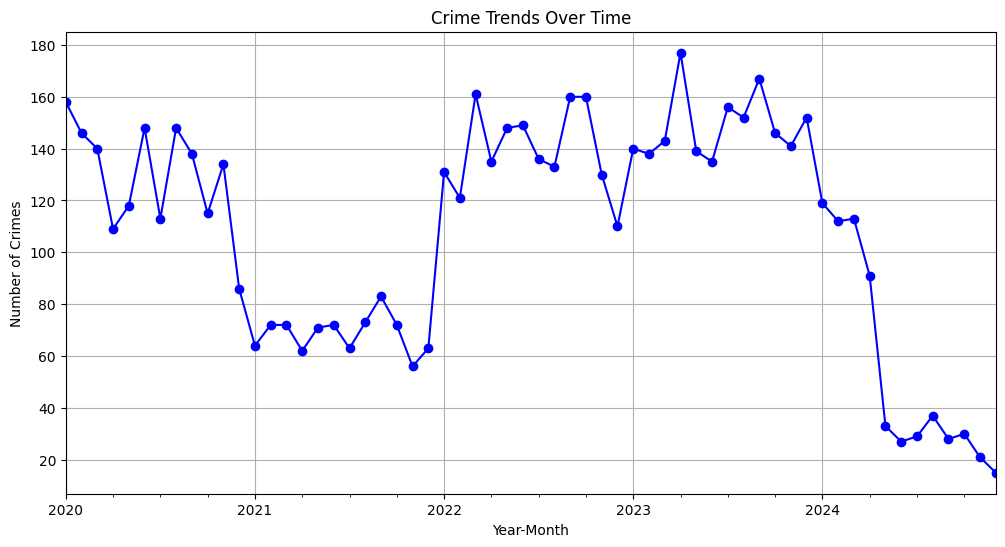

In [64]:
# Crime Trends Over Time
crime_trends = data.groupby('Year_Month').size()
plt.figure(figsize=(12, 6))
crime_trends.plot(kind='line', marker='o', color='blue')
plt.title('Crime Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.savefig('output/TA/Crime Trends Over Time.png')
plt.show()

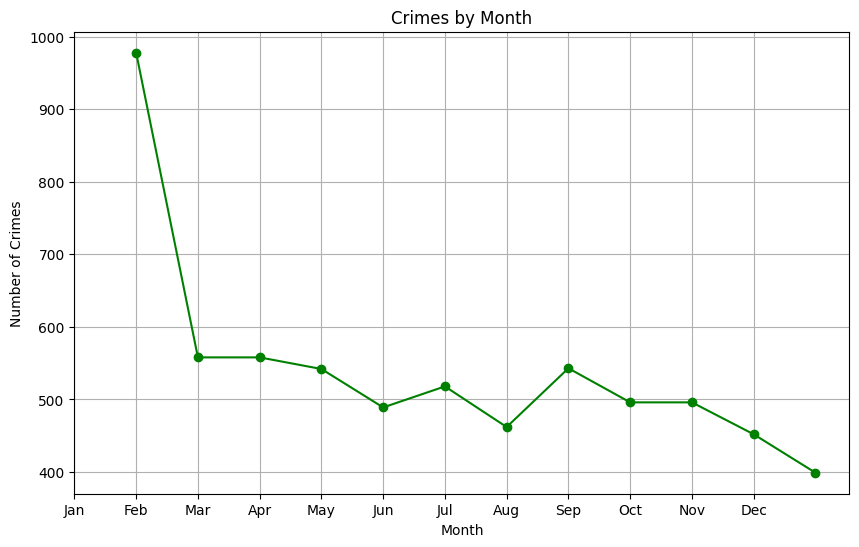

In [65]:
# Crimes by Month
data['Month'] = data['DATE OCC'].dt.month
crimes_by_month = data['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(crimes_by_month.index, crimes_by_month.values, marker='o', linestyle='-', color='g')
plt.title('Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.savefig('output/TA/Crimes_by_Month_Line_Plot.png')
plt.show()


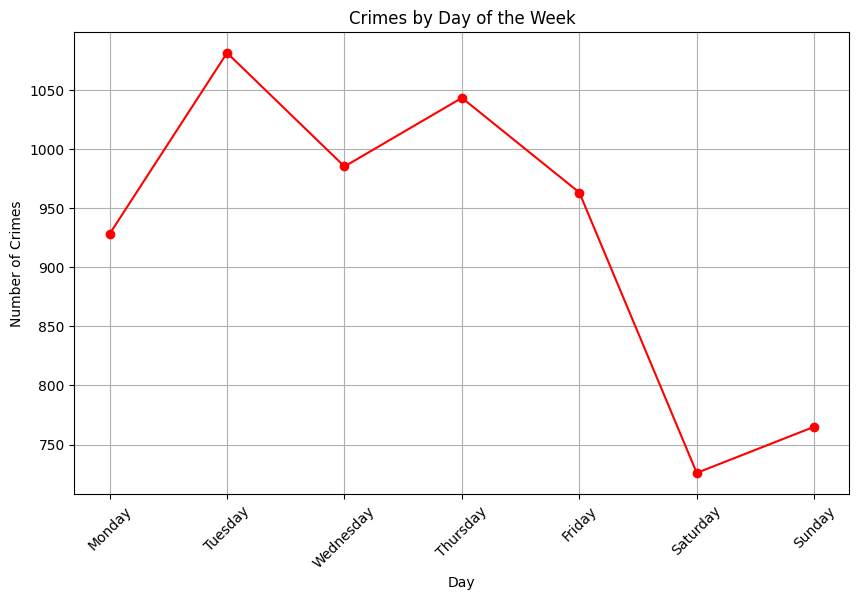

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you already have day_counts as a Series
day_counts = data['Day_of_Week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(day_counts.index, day_counts.values, marker='o', linestyle='-', color='r')
plt.title('Crimes by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('output/TA/Crimes_by_Day_of_the_Week_Line_Plot.png')
plt.show()


# 3. Victim Demographics Analysis

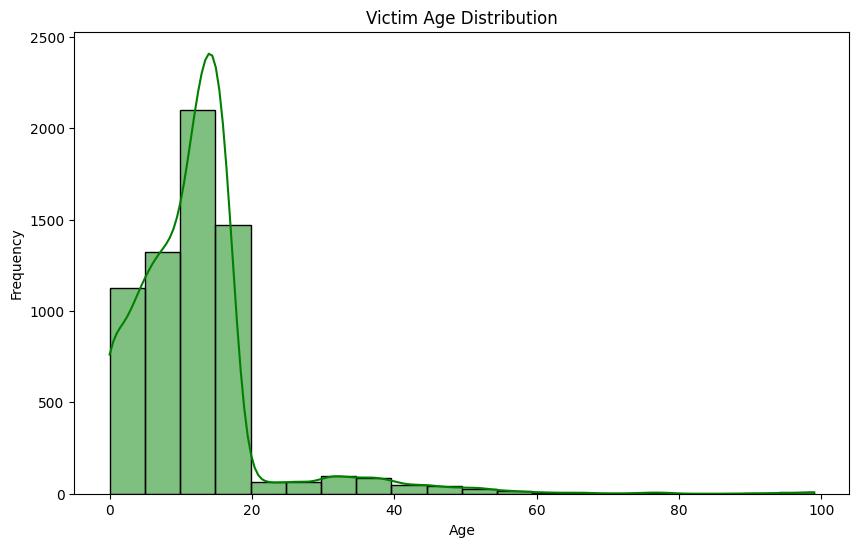

In [67]:
# Victim Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Vict Age'], bins=20, kde=True, color='green')
plt.title('Victim Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('output/VDA/Victim Age Distribution.png')
plt.show()

C:\Users\conne\AppData\Local\Temp\ipykernel_25136\2473556305.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', len(Vict_Sex_counts))


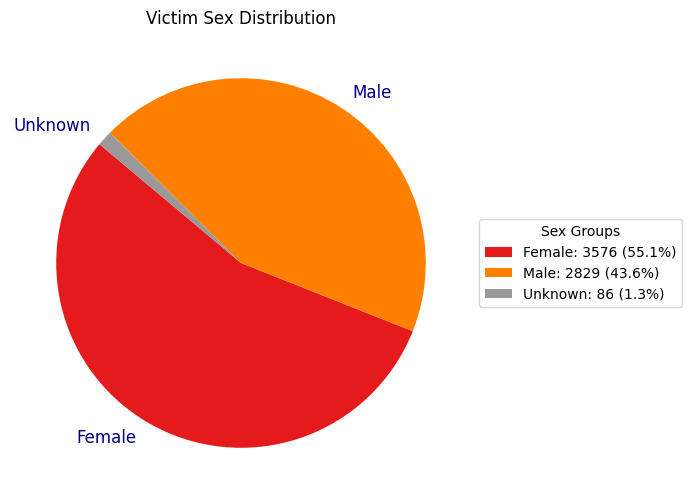

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you already have Vict_Sex_counts as a Series
Vict_Sex_counts = data['Vict Sex'].value_counts()

# Map the original labels to more descriptive labels
label_mapping = {
    'F': 'Female',
    'M': 'Male',
    'X': 'Unknown'
}

# Create custom labels with percentages for the legend
custom_labels = [f'{label_mapping[label]}: {count} ({count/sum(Vict_Sex_counts.values)*100:.1f}%)' 
                 for label, count in zip(Vict_Sex_counts.index, Vict_Sex_counts.values)]

# Apply the label mapping for pie chart labels
mapped_labels = [label_mapping.get(label, label) for label in Vict_Sex_counts.index]

# Create a vibrant colormap
cmap = plt.cm.get_cmap('Set1', len(Vict_Sex_counts))
colors = [cmap(i) for i in range(len(Vict_Sex_counts))]

# Create a pie chart
plt.figure(figsize=(10, 6))
explode = [0.05] * len(Vict_Sex_counts)  # To create separation between slices

wedges, texts = plt.pie(Vict_Sex_counts.values, labels=mapped_labels, startangle=140, colors=colors)

# Customize labels
for i, text in enumerate(texts):
    text.set_fontsize(12)
    text.set_color('navy')

# Add a manually assigned legend with percentages
plt.legend(wedges, custom_labels, title="Sex Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add a title
plt.title('Victim Sex Distribution')

# Save the figure
plt.savefig('output/VDA/Victim_Sex_Distribution_Pie_Chart_Enhanced.png')

# Show the figure
plt.show()


C:\Users\conne\AppData\Local\Temp\ipykernel_25136\406928855.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20c', len(Vict_Descent_counts))


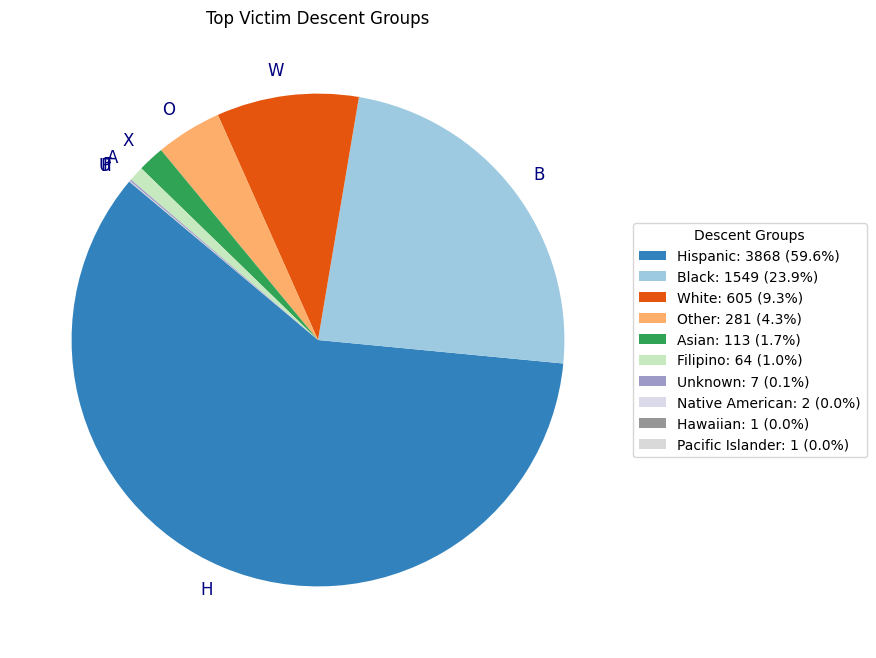

In [69]:
# Assuming you already have Vict_Descent_counts as a Series
Vict_Descent_counts = data['Vict Descent'].value_counts().head(10)

# Define custom labels with percentages for the legend
custom_labels = [f'{label}: {count} ({count/sum(Vict_Descent_counts.values)*100:.1f}%)' 
                 for label, count in zip(['Hispanic', 'Black', 'White', 'Other', 'Asian', 
                                          'Filipino', 'Unknown', 'Native American', 
                                          'Hawaiian', 'Pacific Islander'], 
                                         Vict_Descent_counts.values)]

# Create a vibrant colormap
cmap = plt.cm.get_cmap('tab20c', len(Vict_Descent_counts))
colors = [cmap(i) for i in range(len(Vict_Descent_counts))]

# Create a pie chart
plt.figure(figsize=(12, 8))
explode = [0.05] * len(Vict_Descent_counts)  # To create separation between slices

wedges, texts = plt.pie(Vict_Descent_counts.values, labels=Vict_Descent_counts.index, startangle=140, colors=colors)

# Customize labels
for i, text in enumerate(texts):
    text.set_fontsize(12)
    text.set_color('navy')

# Add a manually assigned legend with percentages
plt.legend(wedges, custom_labels, title="Descent Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Add a title
plt.title('Top Victim Descent Groups')

# Save the figure
plt.savefig('output/VDA/Top_Victim_Descent_Groups_Pie_Chart_Enhanced.png')

# Show the figure
plt.show()


# 4. Crime Characteristics Analysis

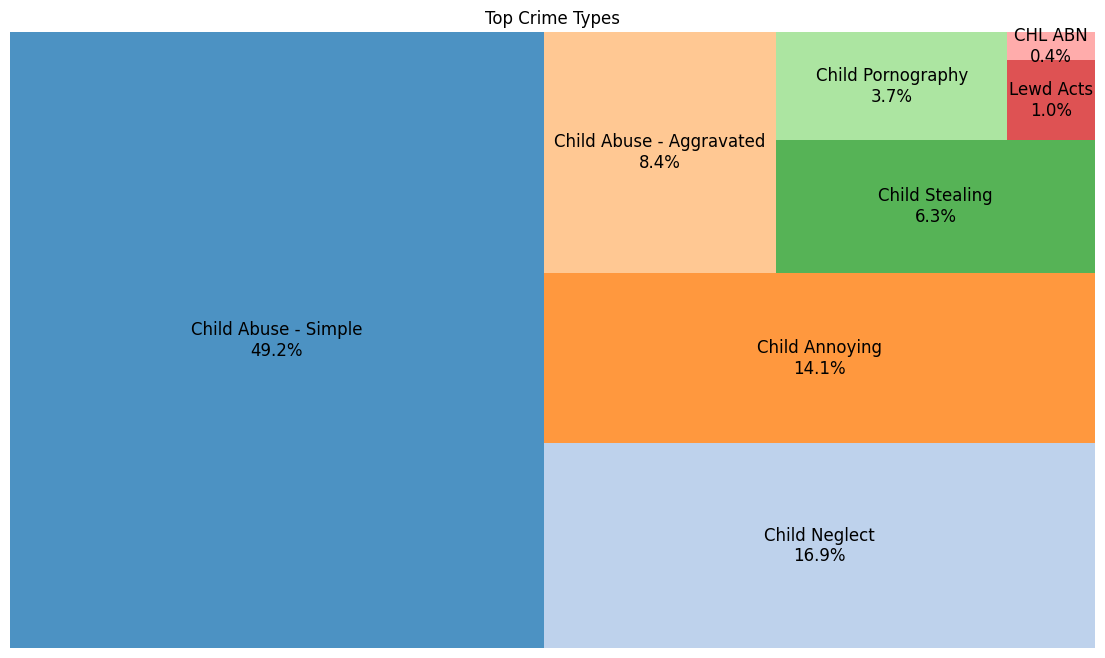

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import squarify

# Assuming you already have crime_counts as a Series
crime_counts = data['Crm Cd Desc'].value_counts()

# CalcuLATe percentages
total_counts = crime_counts.sum()
crime_percentages = (crime_counts / total_counts) * 100

# Define the label mapping dictionary
label_mapping = {
    'CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT': 'Child Abuse - Simple',
    'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT': 'Child Abuse - Aggravated',
    'CHILD ANNOYING (17YRS & UNDER)': 'Child Annoying',
    'CHILD NEGLECT (SEE 300 W.I.C.)': 'Child Neglect',
    'CHILD STEALING': 'Child Stealing',
    'CHILD PORNOGRAPHY': 'Child Pornography',
    'LEWD/LASCIVIOUS ACTS WITH CHILD': 'Lewd Acts',
    'CHILD ABANDONMENT': 'CHL ABN'
}

# Apply the label mapping
beautified_labels = [label_mapping.get(label, label) for label in crime_counts.index]

# Create a colormap
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(len(crime_counts))]

# Create a treemap with improved labels and colors
plt.figure(figsize=(14, 8))
squarify.plot(sizes=crime_counts.values, label=[f'{label}\n{value:.1f}%' for label, value in zip(beautified_labels, crime_percentages)], alpha=0.8, color=colors, text_kwargs={'fontsize':12})

# Add a title and remove axis
plt.title('Top Crime Types')
plt.axis('off')

# Save the figure
plt.savefig('output/CCA/Top_Crime_Types_Treemap_Percentage.png')

# Show the figure
plt.show()


Weapon Desc
STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    3030
UNKNOWN WEAPON/OTHER WEAPON                        410
BELT FLAILING INSTRUMENT/CHAIN                     362
STICK                                               65
VEHICLE                                             34
VERBAL THREAT                                       32
HAND GUN                                            27
BLUNT INSTRUMENT                                    21
OTHER KNIFE                                         11
SEMI-AUTOMATIC PISTOL                               11
Name: count, dtype: int64


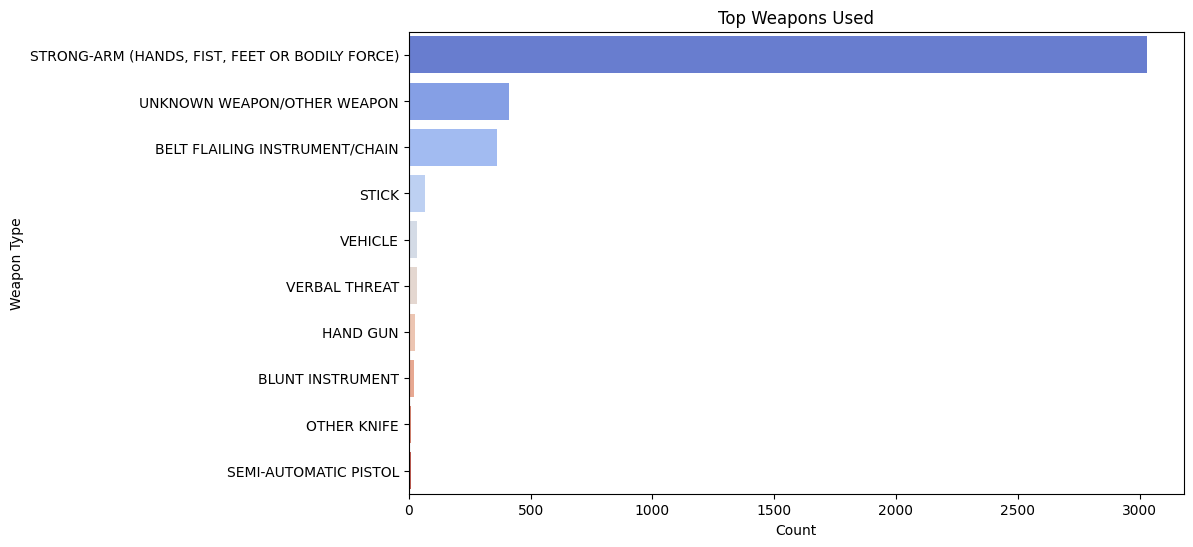

In [71]:
# Weapon Description
weapon_counts = data['Weapon Desc'].dropna().value_counts().head(10)
print(weapon_counts)
plt.figure(figsize=(10, 6))
sns.barplot(y=weapon_counts.index, x=weapon_counts.values, palette='coolwarm',hue=weapon_counts.index,legend=False)
plt.title('Top Weapons Used')
plt.xlabel('Count')
plt.ylabel('Weapon Type')
plt.savefig('output/CCA/Top Weapons Used.png')
plt.show()

In [72]:
data.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'Year_Month', 'Day_of_Week', 'Hour', 'Report_Delay', 'Month'],
      dtype='object')

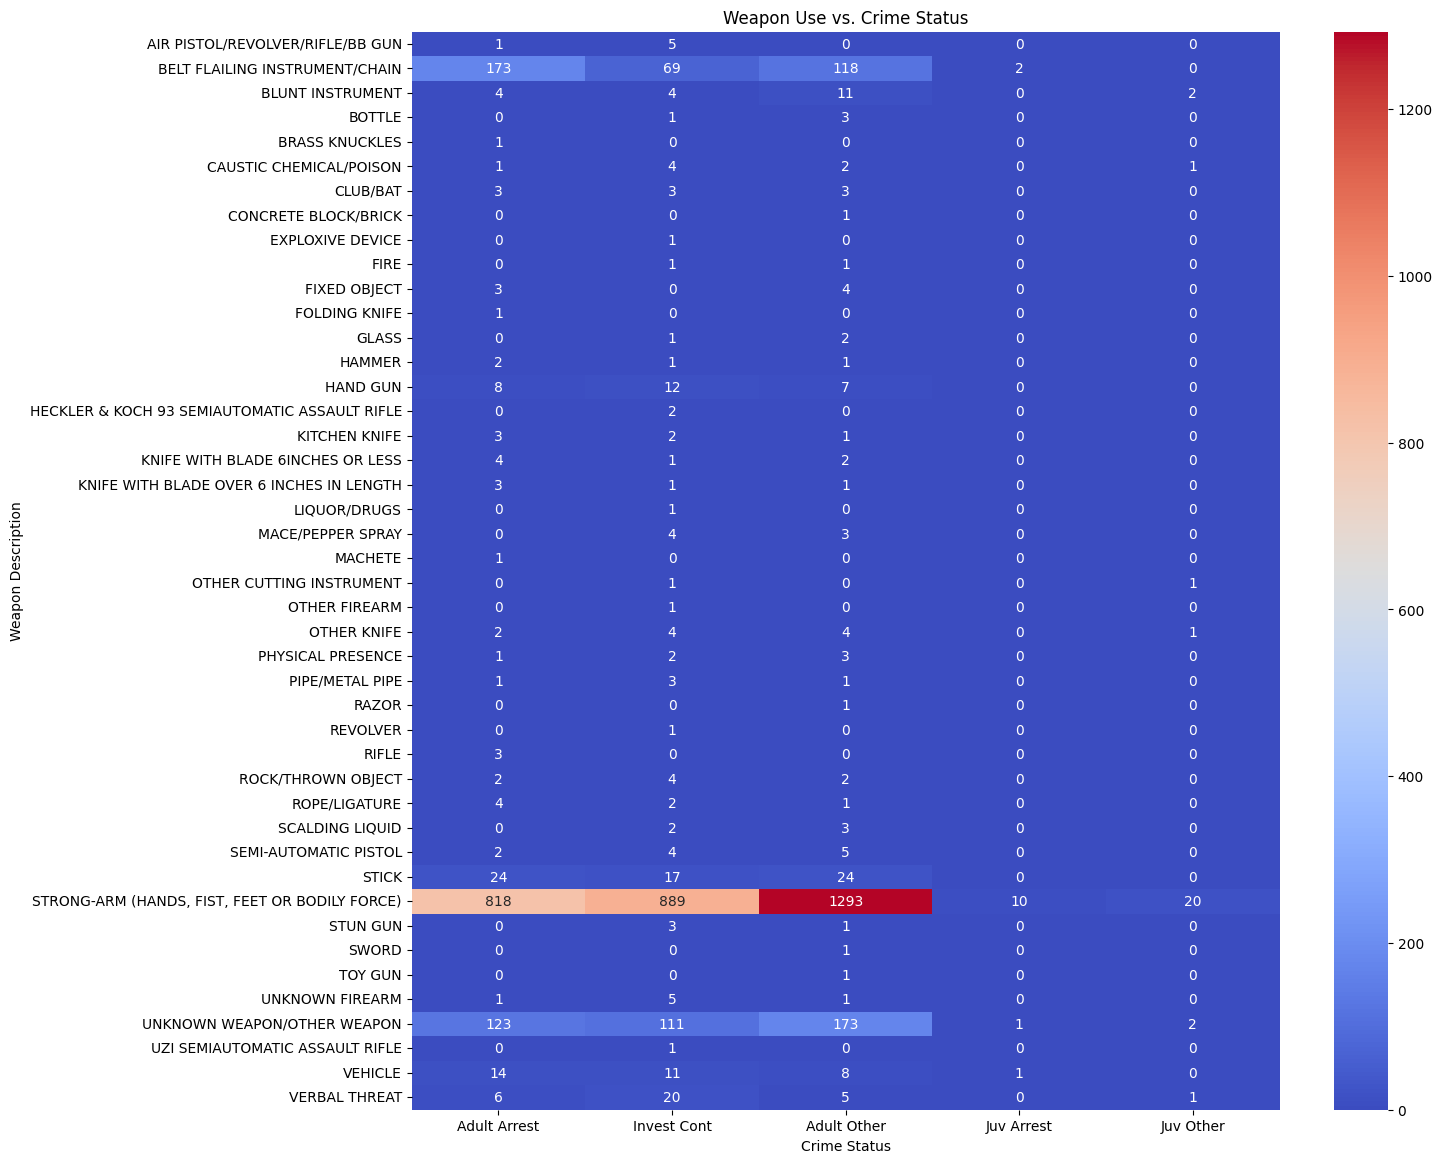

In [73]:
# Weapon Use vs. Crime Status
weapon_severity = data.groupby(['Weapon Desc', 'Status Desc']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 14))
sns.heatmap(weapon_severity, cmap='coolwarm', annot=True, fmt='d')
plt.title('Weapon Use vs. Crime Status')
plt.xlabel('Crime Status')
plt.ylabel('Weapon Description')
plt.savefig('output/CCA/Weapon Use vs Crime Status.png')
plt.show()


In [74]:
data.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'Year_Month', 'Day_of_Week', 'Hour', 'Report_Delay', 'Month'],
      dtype='object')

Premis Desc
SINGLE FAMILY DWELLING                          2582
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    1820
STREET                                           721
SIDEWALK                                         206
PARKING LOT                                      123
ELEMENTARY SCHOOL                                104
JUNIOR HIGH SCHOOL                                86
HIGH SCHOOL                                       84
PARK/PLAYGROUND                                   71
VEHICLE, PASSENGER/TRUCK                          66
Name: count, dtype: int64


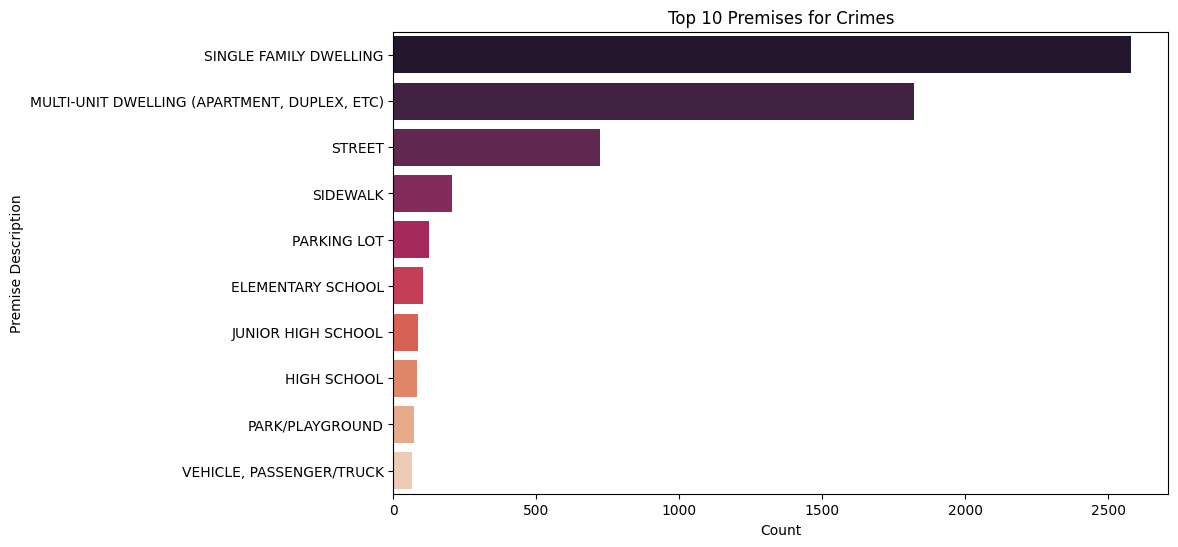

In [75]:
# Premise Type Counts
premise_counts = data['Premis Desc'].value_counts().head(10)
print(premise_counts)
plt.figure(figsize=(10, 6))
sns.barplot(y=premise_counts.index, x=premise_counts.values, palette='rocket',hue=premise_counts.index,legend=False)
plt.title('Top 10 Premises for Crimes')
plt.xlabel('Count')
plt.ylabel('Premise Description')
plt.savefig('output/CCA/Top 10 Premises for Crimes.png')
plt.show()

# 5. Other Relevant Analysis

In [76]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
DR_NO,6491.0,219840581.112617,200100567.0,210218109.5,221219306.0,231110575.0,242112312.0,13288205.065364
Date Rptd,6491,2022-05-06 15:07:20.918194176,2020-01-01 00:00:00,2021-02-03 00:00:00,2022-07-06 00:00:00,2023-06-15 00:00:00,2024-12-08 00:00:00,NaN
DATE OCC,6491,2022-03-31 15:52:49.619473152,2020-01-01 00:00:00,2020-12-04 12:00:00,2022-05-29 00:00:00,2023-05-04 12:00:00,2024-12-05 00:00:00,NaN
TIME OCC,6491.0,1364.096441,1.0,1000.0,1430.0,1825.0,2359.0,600.704074
AREA,6491.0,10.931135,1.0,5.0,11.0,17.0,21.0,6.011625
Rpt Dist No,6491.0,1138.502234,101.0,530.0,1162.0,1738.0,2197.0,600.718608
Part 1-2,6491.0,1.916192,1.0,2.0,2.0,2.0,2.0,0.277122
Crm Cd,6491.0,582.412571,235.0,237.0,627.0,760.0,922.0,220.592054
Vict Age,6491.0,12.115699,0.0,7.0,12.0,15.0,99.0,9.679598
Premis Cd,6491.0,432.307195,101.0,501.0,501.0,502.0,970.0,179.786107


In [77]:
data.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'Year_Month', 'Day_of_Week', 'Hour', 'Report_Delay', 'Month'],
      dtype='object')

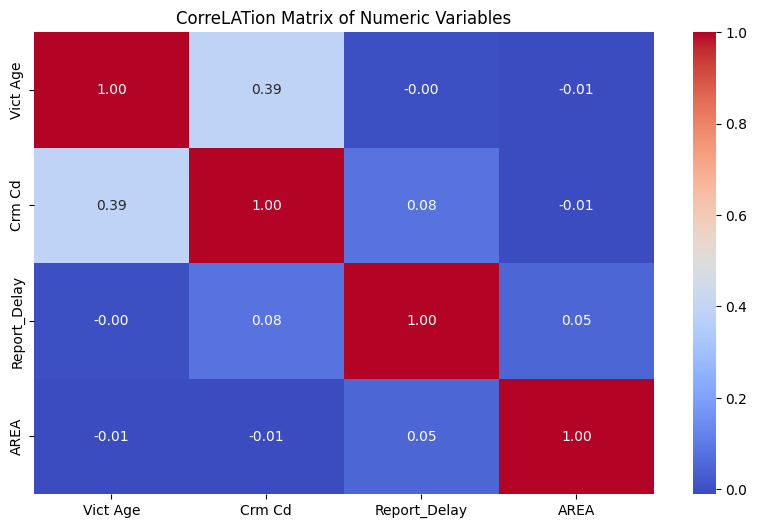

In [78]:
# CorreLATion Matrix
numeric_columns = ['Vict Age', 'Crm Cd', 'Report_Delay', 'AREA']
correLATion_matrix = data[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correLATion_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('CorreLATion Matrix of Numeric Variables')
plt.savefig('output/ORA/CorreLATion Matrix of Numeric Variables.png')
plt.show()

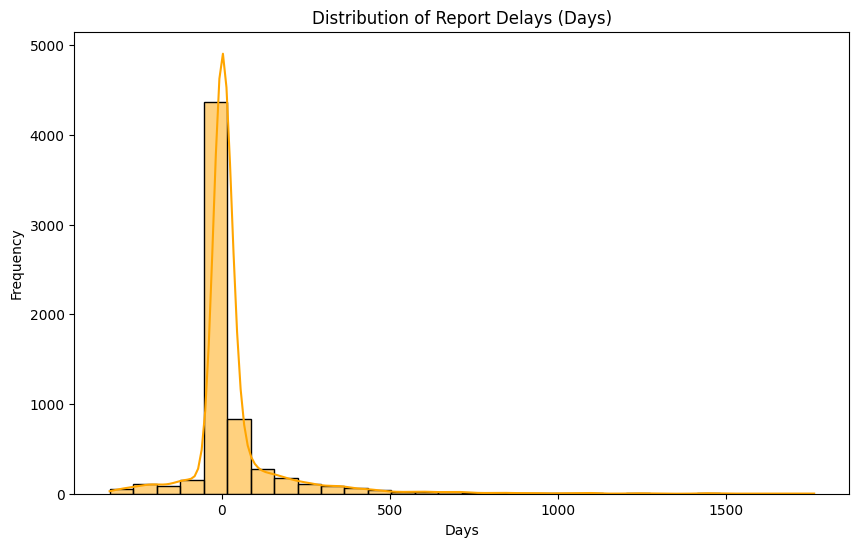

In [79]:
# Report Delay Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Report_Delay'], bins=30, kde=True, color='orange')
plt.title('Distribution of Report Delays (Days)')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.savefig('output/ORA/Distribution of Report Delays (Days).png')
plt.show()

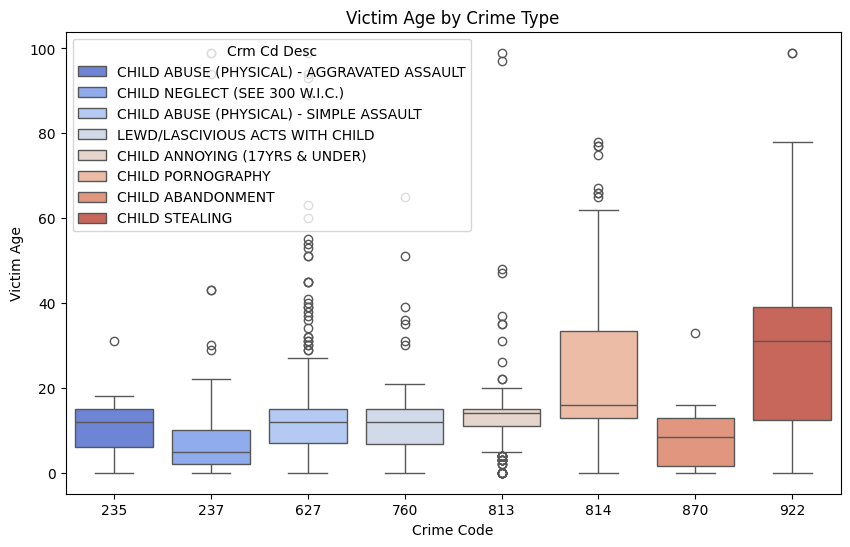

In [80]:
# Victim Age and Crime Code ReLATionship
plt.figure(figsize=(10, 6))
sns.boxplot(x='Crm Cd', y='Vict Age', data=data, palette='coolwarm',hue='Crm Cd Desc')
plt.title('Victim Age by Crime Type')
plt.xlabel('Crime Code')
plt.ylabel('Victim Age')
plt.savefig('output/ORA/Victim Age by Crime Code.png')
plt.show()

# 6. ML

In [81]:
data.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON', 'Year_Month', 'Day_of_Week', 'Hour', 'Report_Delay', 'Month'],
      dtype='object')

In [82]:
# Convert dates to datetime format
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])

# Aggregate data by AREA
AREA_crime_counts = data.groupby('AREA NAME').size().reset_index(name='crime_count')

# Define a threshold for unsafe AREAs (e.g., top 25% crime count)
threshold = np.percentile(AREA_crime_counts['crime_count'], 75)
AREA_crime_counts['safe'] = (AREA_crime_counts['crime_count'] <= threshold).astype(int)  # 1: Safe, 0: Unsafe

# Merge back with the original data
data = data.merge(AREA_crime_counts[['AREA NAME', 'safe']], on='AREA NAME')

# Features and target
X = data[['LAT', 'LON', 'Vict Age', 'TIME OCC']]  # Example features
y = data['safe']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       823
           1       1.00      1.00      1.00      1125

    accuracy                           0.99      1948
   macro avg       0.99      0.99      0.99      1948
weighted avg       0.99      0.99      0.99      1948



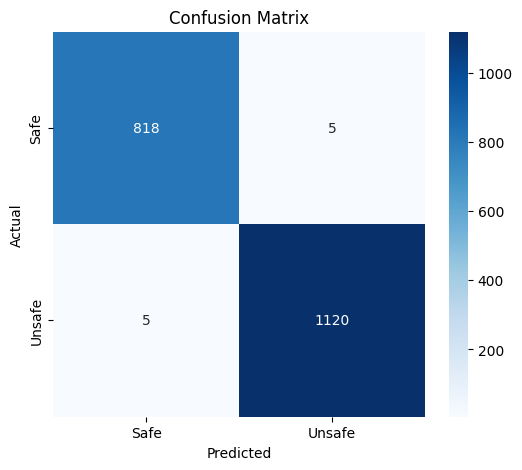

In [83]:
# Visualization

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe', 'Unsafe'], yticklabels=['Safe', 'Unsafe'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


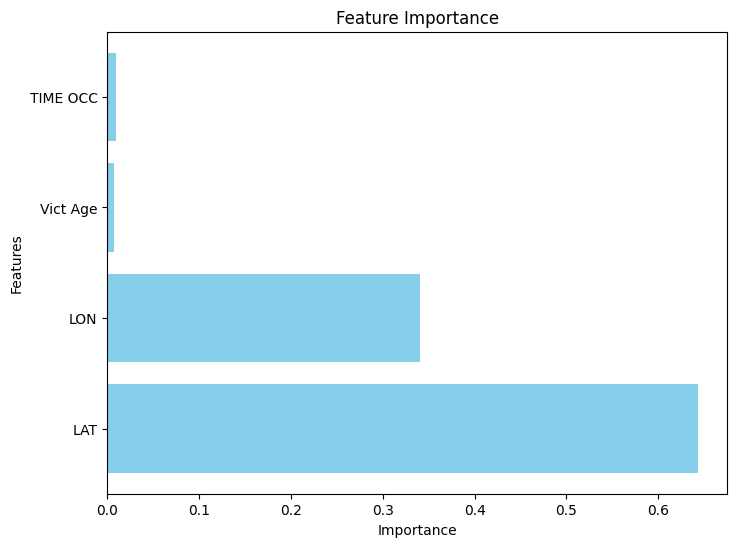

In [84]:
# 2. Feature Importance
feature_importance = clf.feature_importances_
features = X.columns
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()



In [85]:
# Display Safe and Unsafe Areas
safe_AREAs = AREA_crime_counts[AREA_crime_counts['safe'] == 1]['AREA NAME'].tolist()
unsafe_AREAs = AREA_crime_counts[AREA_crime_counts['safe'] == 0]['AREA NAME'].tolist()

print("Safe Areas:\n", safe_AREAs)
print("\nUnsafe Areas:\n", unsafe_AREAs)

Safe Areas:
 ['Central', 'Devonshire', 'Foothill', 'Hollenbeck', 'Hollywood', 'N Hollywood', 'Newton', 'Northeast', 'Olympic', 'Pacific', 'Rampart', 'Topanga', 'Van Nuys', 'West LA', 'West Valley', 'Wilshire']

Unsafe Areas:
 ['77th Street', 'Harbor', 'Mission', 'Southeast', 'Southwest']


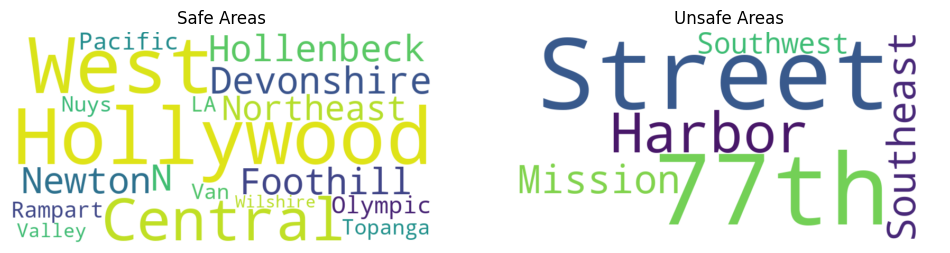

In [87]:
# Combine all AREA names into a single string for wordcloud
safe_AREA_text = ' '.join(safe_AREAs)
unsafe_AREA_text = ' '.join(unsafe_AREAs)

# Generate word clouds
wordcloud_safe = WordCloud(width=800, height=400, background_color='white').generate(safe_AREA_text)
wordcloud_unsafe = WordCloud(width=800, height=400, background_color='white').generate(unsafe_AREA_text)

# Plot word clouds
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_safe, interpolation='bilinear')
plt.title('Safe Areas')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_unsafe, interpolation='bilinear')
plt.title('Unsafe Areas')
plt.axis('off')

plt.show()


In [88]:
# Convert dates to datetime format (removing timezone info if present)
data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])

# Group by month using 'YYYY-MM' format
data['month'] = data['DATE OCC'].dt.strftime('%Y-%m')  # Creates 'YYYY-MM' format
monthly_crime = data.groupby('month').size().reset_index(name='crime_count')

# Prepare time-series data
values = monthly_crime['crime_count'].values.reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values)




In [89]:
# Create sequences for LSTM
sequence_length = 12  # Look back 12 months
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Split into training and testing
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



e:\Shoban-NCI\VS_Code_WS\pycaret_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - loss: 0.1463 - val_loss: 0.0068
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0848 - val_loss: 0.0153
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0546 - val_loss: 0.0416
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0310 - val_loss: 0.0883
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0288 - val_loss: 0.1236
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0385 - val_loss: 0.1171
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0353 - val_loss: 0.0917
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0293 - val_loss: 0.0677
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0248 - val_loss: 0.0511
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0237 - val_loss: 0.0416
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0291 - val_loss: 0.0378
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0296 - val_loss: 0.0372


In [90]:
# Forecasting for the next 12 months
predictions = []
last_sequence = X_test[-1]

for _ in range(12):  # Predict next 12 months
    pred = model.predict(last_sequence.reshape(1, -1, 1), verbose=0)
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred).reshape(sequence_length, 1)

# Reverse scaling
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [92]:
# Step 1: Create a date range for the next 12 months (based on the last month in your data)
last_month = monthly_crime['month'].iloc[-1]  # Get the last month in your data
forecast_months = pd.date_range(last_month, periods=13, freq='M')[1:].strftime('%Y-%m')  # Exclude the last month

# Step 2: Create a DataFrame for the forecasted values
forecasted_crime = pd.DataFrame({
    'month': forecast_months,
    'crime_count': predictions.flatten()  # flatten the predicted values (in case it's a 2D array)
})

# Step 3: Concatenate the original data with the forecasted values
combined_data = pd.concat([monthly_crime, forecasted_crime], ignore_index=True)


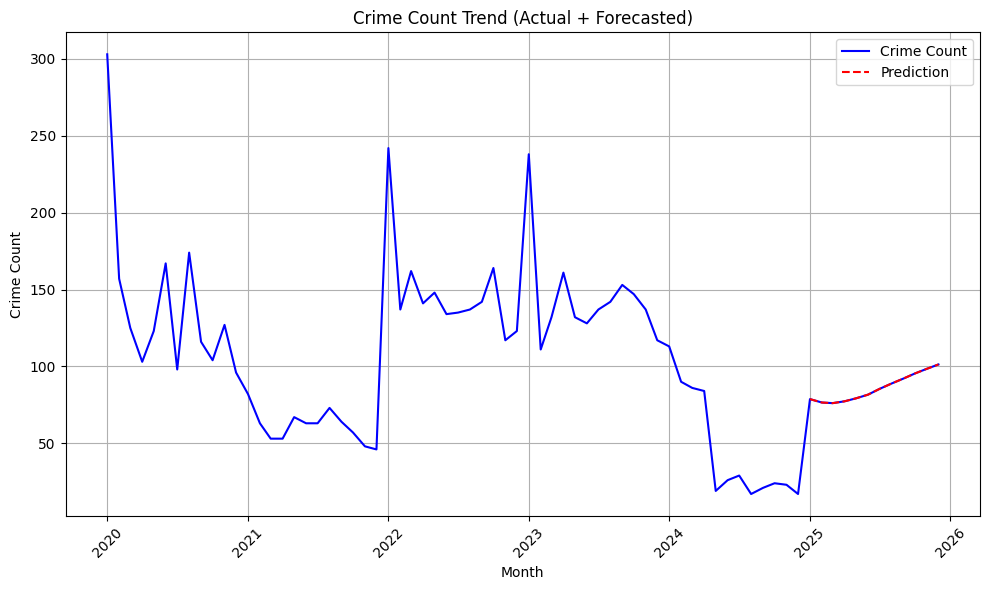

In [93]:
# Step 1: Convert 'month' column to datetime format for proper plotting
combined_data['month'] = pd.to_datetime(combined_data['month'], format='%Y-%m')

# Step 2: Split data into two parts - overall and last 12 months
last_12_months = combined_data.iloc[-12:]
previous_months = combined_data

# Step 3: Plot the data
plt.figure(figsize=(10, 6))

# Plot previous months' data
plt.plot(previous_months['month'], previous_months['crime_count'], label='Crime Count', color='blue')

# Plot last 12 months' data with a different style
plt.plot(last_12_months['month'], last_12_months['crime_count'], label='Prediction', color='red', linestyle='--')

# Formatting the plot
plt.xticks(rotation=45)  # Rotate month labels for better visibility
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.title('Crime Count Trend (Actual + Forecasted)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes
import folium
from folium.plugins import MarkerCluster

# Load data and select relevant columns
selected_features = ['Vict Age', 'Vict Sex', 'LAT', 'LON']
data = data[selected_features].dropna()  # Remove rows with missing values

# Encode categorical variable (Vict Sex)
data['Vict Sex_encoded'] = data['Vict Sex'].astype('category').cat.codes  # M (0), F (1), etc.

# Normalize numerical features (LAT, LON, Vict Age)
scaler = MinMaxScaler()
data[['Vict Age_scaled', 'LAT_scaled', 'LON_scaled']] = scaler.fit_transform(data[['Vict Age', 'LAT', 'LON']])

# Prepare data for K-Prototypes
# Separate categorical and numerical features
numerical_data = data[['Vict Age_scaled', 'LAT_scaled', 'LON_scaled']].values
categorical_data = data[['Vict Sex_encoded']].values

# Combine numerical and categorical features
final_data = np.hstack((numerical_data, categorical_data))  # Numerical first, then categorical

# Determine the index of the categorical column(s)
categorical_columns = [final_data.shape[1] - 1]  # Last column is categorical ('Vict Sex_encoded')

# Apply K-Prototypes clustering
kproto = KPrototypes(n_clusters=3, init='Cao', random_state=42)  # Adjust 'n_clusters' as needed
clusters = kproto.fit_predict(final_data, categorical=categorical_columns)

# Add cluster labels to the original data
data['cluster'] = clusters

# Analyze and describe each cluster
cluster_labels = {}
for cluster_id in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster_id]
        
    # Assign labels based on descriptive statistics (replace with actual insights)
    if cluster_id == 0:
        cluster_labels[cluster_id] = "Crimes in Urban Areas"
    elif cluster_id == 1:
        cluster_labels[cluster_id] = "Gender-Targeted Crimes in Mixed Locations"
    elif cluster_id == 2:
        cluster_labels[cluster_id] = "Crimes in Suburban Areas"
    
    # Print cluster characteristics
    print(f"\nCluster {cluster_labels[cluster_id]} characteristics:")
    print(cluster_data[['Vict Age', 'Vict Sex', 'LAT', 'LON']].describe())
    
    # CalcuLATe gender distribution
    gender_counts = cluster_data['Vict Sex'].value_counts()
    print(f"Gender Distribution:\n{gender_counts}")
    
    # Analyze geographical spread
    print(f"Geographical Range (LAT/LON):\n"
          f"LATitude: {cluster_data['LAT'].min()} to {cluster_data['LAT'].max()}\n"
          f"LONgitude: {cluster_data['LON'].min()} to {cluster_data['LON'].max()}\n")

# Map cluster labels
data['cluster_label'] = data['cluster'].map(cluster_labels)

# Integrate with GeoJSON map visualization

# Load your GeoJSON file (replace 'path_to_your_geojson_file.geojson' with your actual file path)
geojson_file = 'E:\Shoban-NCI\VS_Code_WS\Prog_for_AI\CA2\input\LA_County_Boundary.geojson'

# Center the map around Los Angeles
la_map = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# Add GeoJSON to the map
folium.GeoJson(geojson_file, name='geojson').add_to(la_map)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(la_map)

# Define colors for each cluster
colors = {
    'Crimes in Urban Areas': 'blue',
    'Gender-Targeted Crimes in Mixed Locations': 'green',
    'Crimes in Suburban Areas': 'red'
}

# Add markers for each point in the dataset
for idx, row in data.iterrows():
    folium.Marker(
        location=[row['LAT'], row['LON']],
        popup=f"Age: {row['Vict Age']}<br>Sex: {row['Vict Sex']}<br>Cluster: {row['cluster_label']}",
        icon=folium.Icon(color=colors.get(row['cluster_label'], 'gray'))
    ).add_to(marker_cluster)

# Add layer control to the map
folium.LayerControl().add_to(la_map)

# Save the map to an HTML file
la_map.save('output/LA_Crime_Map_with_GeoJSON.html')



Cluster Crimes in Urban Areas characteristics:
          Vict Age          LAT          LON
count  3464.000000  3464.000000  3464.000000
mean     11.331986    34.029439  -118.214856
std       5.274947     1.164971     4.021378
min       0.000000     0.000000  -118.649100
25%       8.000000    33.989600  -118.440000
50%      13.000000    34.052200  -118.308900
75%      15.000000    34.193900  -118.273900
max      30.000000    34.327500     0.000000
Gender Distribution:
Vict Sex
F    3446
X      18
Name: count, dtype: int64
Geographical Range (LAT/LON):
LATitude: 0.0 to 34.3275
LONgitude: -118.6491 to 0.0


Cluster Gender-Targeted Crimes in Mixed Locations characteristics:
         Vict Age         LAT         LON
count  369.000000  369.000000  369.000000
mean    42.173442   34.077932 -118.355153
std     13.854337    0.120243    0.104780
min     26.000000   33.726100 -118.649300
25%     33.000000   33.999300 -118.431200
50%     38.000000   34.061000 -118.321400
75%     46.000000   34.18

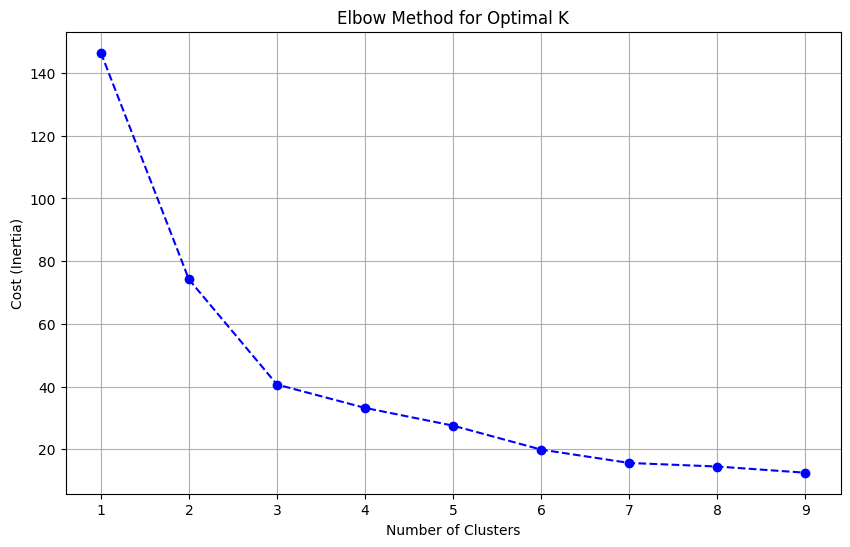

In [95]:
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

# CalcuLATe cost (inertia) for different numbers of clusters
costs = []
num_clusters = range(1, 10)  # Test clusters from 1 to 9

for k in num_clusters:
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    kproto.fit(final_data, categorical=categorical_columns)
    costs.append(kproto.cost_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, costs, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost (Inertia)')
plt.xticks(num_clusters)
plt.grid()
plt.show()
